# 00_Showcase ecDHFR: a FEATHER walkthrough

The tutorial dataset can be downloaded from [this link](https://figshare.com/ndownloader/files/48153751).

## import

In [1]:
from pigeon_feather.data import *
from pigeon_feather.plot import *
from pigeon_feather.hxio import *
from pigeon_feather.spectra import *


import numpy as np
import pandas as pd

In [3]:
# make folders for results

import datetime
import os

out_path = "./data/bayesian_hdx_input_20240722"

today_date = datetime.date.today().strftime("%Y%m%d")
# today_date = '20240722'
results_path = os.path.join(out_path, f"ecDHFR_results_{today_date}")

if not os.path.exists(results_path):
    os.makedirs(results_path)


## load the data

In [2]:
tables = ['./data/ecDHFR_tutorial.csv']

ranges = ['./data/rangeslist.csv']


raw_spectra_paths = [
    f"./data/SpecExport/",
]

protein_sequence = "MTGHHHHHHENLYFQSISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLDKPVIMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDEAIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVEGDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR"

# load the data
hdxms_data_list = []
for i in range(len(tables)):
    # for i in [4]:
    print(tables[i])

    
    # read the data and clean it
    cleaned = read_hdx_tables([tables[i]], [ranges[i]], exclude=False, states_subset=['APO','TRI'])
    
    # convert the cleaned data to hdxms data object
    hdxms_data = load_dataframe_to_hdxmsdata(
        cleaned,
        n_fastamides=2,
        protein_sequence=protein_sequence,
        fulld_approx=False,
        saturation=0.9,
    )

    # load the raw ms data to the hdxms data object
    load_raw_ms_to_hdxms_data(
        hdxms_data,
        raw_spectra_paths[i],
    )

    hdxms_data_list.append(hdxms_data)



./data/ecDHFR_tutorial.csv
rangeslist included !
Removed 0 peptides from state APO due to missing raw MS data.
Removed 70 peptides from state APO due to high back exchange.
Removed 2 peptides from state TRI due to missing raw MS data.
Removed 70 peptides from state TRI due to high back exchange.
Done loading raw MS data.


In [3]:
hdxms_data_list

In [4]:
# save the raw data as a pickle file
import pickle

today = datetime.date.today().strftime("%Y%m%d")
today = "20240722"

# with open(f"./data/hdxms_data_raw_{today}.pkl", "wb") as f:
#     pickle.dump(hdxms_data_list, f)

with open(f"./data/hdxms_data_raw_{today}.pkl", "rb") as f:
    hdxms_data_list = pickle.load(f)

In [5]:
from pigeon_feather.hxio import get_all_statics_info

get_all_statics_info(hdxms_data_list)

                    HDX-MS Data Statistics
States names: ['APO', 'TRI']
Time course (s): [46.0, 373.5, 572.5, 2011.0, 7772.0, 30811.5, 43292.0]
Number of time points: 7
Protein sequence length: 174
Average coverage: 0.93
Number of unique peptides: 186
Average peptide length: 9.4
Redundancy (based on average coverage): 10.0
Average peptide length to redundancy ratio: 0.9
Backexchange average, IQR: 0.19, 0.15


## back exchange correction

back exchange correction for peptides with experimental full deuteration data based its closest match in the database

In [6]:
tools.backexchange_correction(hdxms_data_list)

Number of peptides with experimental max_d: 358
Number of peptides with no experimental max_d: 12


In [7]:
# grab all the peptides

all_peps = [
    pep
    for data in hdxms_data_list[:]
    for state in data.states
    for pep in state.peptides
]

len(set([pep.identifier for pep in all_peps]))

186

(array([18., 16., 10., 20., 30., 20., 42., 20., 24., 40., 38., 28., 20.,
        14.,  8.,  6.,  4.,  2.,  2.,  8.]),
 array([0.60127572, 0.62628601, 0.6512963 , 0.67630658, 0.70131687,
        0.72632716, 0.75133745, 0.77634774, 0.80135802, 0.82636831,
        0.8513786 , 0.87638889, 0.90139918, 0.92640947, 0.95141975,
        0.97643004, 1.00144033, 1.02645062, 1.05146091, 1.07647119,
        1.10148148]),
 <BarContainer object of 20 artists>)

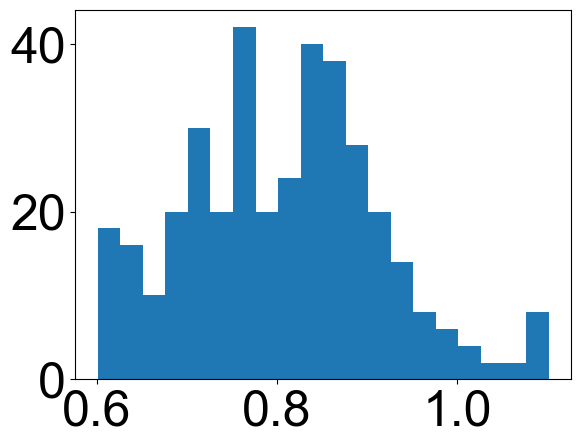

In [8]:
max_d = [pep.max_d / pep.theo_max_d for pep in all_peps]
plt.hist(max_d, bins=20)

## plot uptake plots

In [11]:
# option 1
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
from pigeon_feather.analysis import get_index_offset
from matplotlib.ticker import LogLocator


font = {"family": "Arial", "weight": "normal", "size": 36}
axes = {"titlesize": 36, "titleweight": "bold", "labelsize": 36, "linewidth": 5}
plt.rc("font", **font)
plt.rc("axes", **axes)
plt.rc("lines", lw=5)

colors = ["k", "red", "blue", "purple", "gray", "orange", "yellow", "green", "brown"]


all_peps = [
    peptide
    for hdxms_data in hdxms_data_list
    for state in hdxms_data.states
    for peptide in state.peptides
    if peptide.note is None and state.state_name != "RAT"
]
all_idfs = [pep for pep in all_peps if pep.unique_num_timepoints > 5]
all_idfs = list(set([peptide.identifier for peptide in all_peps]))[:]
all_idfs.sort(key=lambda x: int(re.search(r"(-?\d+)", x).group()))



def idf_to_pep(idf):
    return [pep for pep in all_peps if pep.identifier == idf][0]

# num_subplots_per_figure = 100
num_subplots_per_figure = 250
num_figures = math.ceil(len(all_idfs) / num_subplots_per_figure)


all_idfs_subset = all_idfs[:]

for fig_index in range(num_figures):
    # Select the subset of errors for the current figure
    selected_idf = all_idfs_subset[
        fig_index * num_subplots_per_figure : (fig_index + 1) * num_subplots_per_figure
    ]
    num_col = math.ceil(len(selected_idf) / 5)

    fig, axs = plt.subplots(
        num_col, 5, figsize=(9 * 5, 8 * num_col)
    )  # Adjust subplot size as needed

    for i, idf in enumerate(selected_idf):
        ax = axs[i // 5, i % 5]


        pep = idf_to_pep(idf)
        ax.axhline(y=pep.max_d, color='lightgray', linestyle='--', linewidth=5)


        uptake = UptakePlot(
            hdxms_data_list,
            idf,
            states_subset=["APO", "TRI"],
            if_plot_fit=False,
            figure=fig,
            ax=ax,
        )

        ax.set_xlim(1e1, 1e5)
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))


        y_max = pep.theo_max_d/hdxms_data_list[0].saturation
        ax.set_ylim(-0.5, y_max + 0.5)


        #Custom legend
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [label for label in labels if label in ["APO", "TRI"]]
        new_handles = [
            handle
            for handle, label in zip(handles, labels)
            if label in ["APO", "TRI"]  
        ]
        ax.legend(new_handles, new_labels, title="state", title_fontsize="small",loc='best')


    # Layout adjustment and save
    fig.tight_layout()
    fig.savefig(f"{results_path}/DHFR_exp_uptake_{fig_index}.pdf")

## peptide subtraction

In [9]:
# [state.add_all_subtract() for data in hdxms_data_list for state in data.states]
# add_new_peptides_by_subtract()
for i in range(1):
    [
        state.add_new_peptides_by_subtract()
        for data in hdxms_data_list[:]
        for state in data.states
    ]

117 new peptides added to the APO state.
126 new peptides added to the TRI state.


In [10]:
[state.num_subtracted_added for data in hdxms_data_list for state in data.states]

[117, 126]

save the data as a pickle file for later use,  and write to files used for bayesian sampling

In [11]:
import os

out_path = f"./data/bayesian_hdx_input_{today}"
if not os.path.exists(out_path):
    os.makedirs(out_path)


import pickle

with open(f"{out_path}/hdxms_data_list.pkl", "wb") as f:
    pickle.dump(hdxms_data_list, f)

# with open(f"{out_path}/hdxms_data_list.pkl", "rb") as f:
#     hdxms_data_list = pickle.load(f)

## inputs for MCMC sampling

In [12]:
exp_names = [
    "dhfr_tutorial_dataset",
]

for i in range(len(hdxms_data_list)):
    # exp_name = raw_spectra_paths[i].split('/')[-2].split('SpecExport_')[-1]
    exp_name = exp_names[i]
    export_iso_files(
        hdxms_data_list[i], outdir=f"{out_path}/spectra_{exp_name}", overwrite=True
    )
    df = revert_hdxmsdata_to_dataframe(hdxms_data_list[i])
    convert_dataframe_to_bayesianhdx_format(
        df, protein_name=exp_name, OUTPATH=f"{out_path}"
    )

    print(exp_name)

Isotope files saved to ./data/bayesian_hdx_input_20240722/spectra_dhfr_tutorial_dataset
Reminder: sequence contains fastamides !!!
Reminder: sequence contains fastamides !!!
Data saved to ./data/bayesian_hdx_input_20240722
dhfr_tutorial_dataset


In [15]:
# write ready to run script for each state

protein_sequence = "MTGHHHHHHENLYFQSISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLDKPVIMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDEAIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVEGDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR"

state_names = list(
    set([state.state_name for data in hdxms_data_list for state in data.states])
)
for protein_state in state_names:
    script = tools.generate_bayesian_hdx_script(
        exp_names,
        protein_sequence,
        protein_state,
        base_directory=".",
        making_chunks=True,
        pH=7.0,
        temperature=293.0,
        saturation=0.9,
        rerun_num=3,
        extreme_value_prior=False,
        structural_prior=False,
    )

    with open(f"{out_path}/run_bayesian_hdx_{protein_state}_chunks.py", "w") as f:
        f.write(script)




two priors

In [14]:
# uptake prior
#tools.generate_extreme_value_prior(hdxms_data_list, out_path)


# structural prior

# solvated_pdbs = [
#     "./data/5DFR_APO_relaxed_best_solvated.pdb",
#     "./data/6XG5_TRI_relaxed_best_solvated.pdb",
#     "./data/1RG7_MTX_relaxed_best_solvated.pdb",
# ]

# for i, state_name in enumerate(["APO", "TRI", "MTX"]):


#     tools.generate_structural_prior(
#         protein_sequence, solvated_pdbs[i], out_path, state_name
#     )

## run the sampling

You can run the script in the terminal with the following command:

```sh
cd ./data/bayesian_hdx_input_20240722
python run_bayesian_hdx_APO_chunks.py
```

The simulations usually take several hours, but the duration varies based on the size of the dataset (number of peptides, time points, and replicates).



## Analysis

In [13]:
import pickle

class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if name == "ProteinState":
            from pigeon_feather.data import ProteinState

            return ProteinState
        if name == "HDXMSData":
            from pigeon_feather.data import HDXMSData

            return HDXMSData
        if name == "Peptide":
            from pigeon_feather.data import Peptide

            return Peptide
        if name == "Timepoint":
            from pigeon_feather.data import Timepoint

            return Timepoint
        return super().find_class(module, name)


# read pcikle
with open(f"{out_path}/hdxms_data_list.pkl", "rb") as f:
    hdxms_data_list = CustomUnpickler(f).load()

In [15]:
hdxms_data_list

In [16]:
for data in hdxms_data_list:
    for state in data.states:
        state.peptides = [pep for pep in state.peptides if pep.note is None]
        for pep in state.peptides:
            pep.timepoints = [tp for tp in pep.timepoints if tp.note is None]

create an Analysis object and load the results, note: the temperature and pH are crucial to calculate the instrisic exchange rates. make sure to input the correct ones. The chunk size and chunk number can be altered by user. in this tutorial it was automaticaly determined by a help function.

In [17]:
from pigeon_feather.analysis import Analysis, get_index_offset
from pigeon_feather.tools import optimal_chunks
import matplotlib.pyplot as plt

RUN_NUM = 3

apo_states = [
    state
    for data in hdxms_data_list
    for state in data.states
    if state.state_name == "APO"
]

tri_states = [
    state
    for data in hdxms_data_list
    for state in data.states
    if state.state_name == "TRI"
]

ana_apo_1 = Analysis(apo_states, temperature=293.0, pH=7.0)

chunk_num, chunk_size = optimal_chunks(len(ana_apo_1.protein_sequence))
ana_apo_1.load_bayesian_hdx_oupt_chunks(
    chunk_size=chunk_size,
    chunk_num=chunk_num,
    state_name="APO",
    run_num=RUN_NUM,
    N=200,
    bayesian_hdx_data_folder=f"{out_path}/bayesian_hdx_output_chunks",
)


ana_tri_1 = Analysis(tri_states, temperature=293.0, pH=7.0)

ana_tri_1.load_bayesian_hdx_oupt_chunks(
    chunk_size=chunk_size,
    chunk_num=chunk_num,
    state_name="TRI",
    run_num=RUN_NUM,
    N=200,
    bayesian_hdx_data_folder=f"{out_path}/bayesian_hdx_output_chunks",
)

In [18]:
# for mini in ana_apo_1.results_obj.mini_peps:
#     print(mini.std_within_clusters_log_kex)

## Fitting check

two fitting check functions are available: 1. centroid level fitting check 2. isotopic mass envelope fitting check. 


In [19]:
from pigeon_feather.analysis import (
    check_fitted_isotope_envelope,
    check_fitted_peptide_uptake,
)

### envelope check

In [20]:
check_state_name = "APO"
check_ana_obj = ana_apo_1


all_peps = [
    pep
    for data in hdxms_data_list
    for state in data.states
    for pep in state.peptides
    if state.state_name == check_state_name and pep.note is None
]
all_tps = [
    tp
    for pep in all_peps
    for tp in pep.timepoints
    if pep.get_timepoint(0) is not None and tp.deut_time != np.inf and tp.deut_time != 0
]


0.18086398727111275

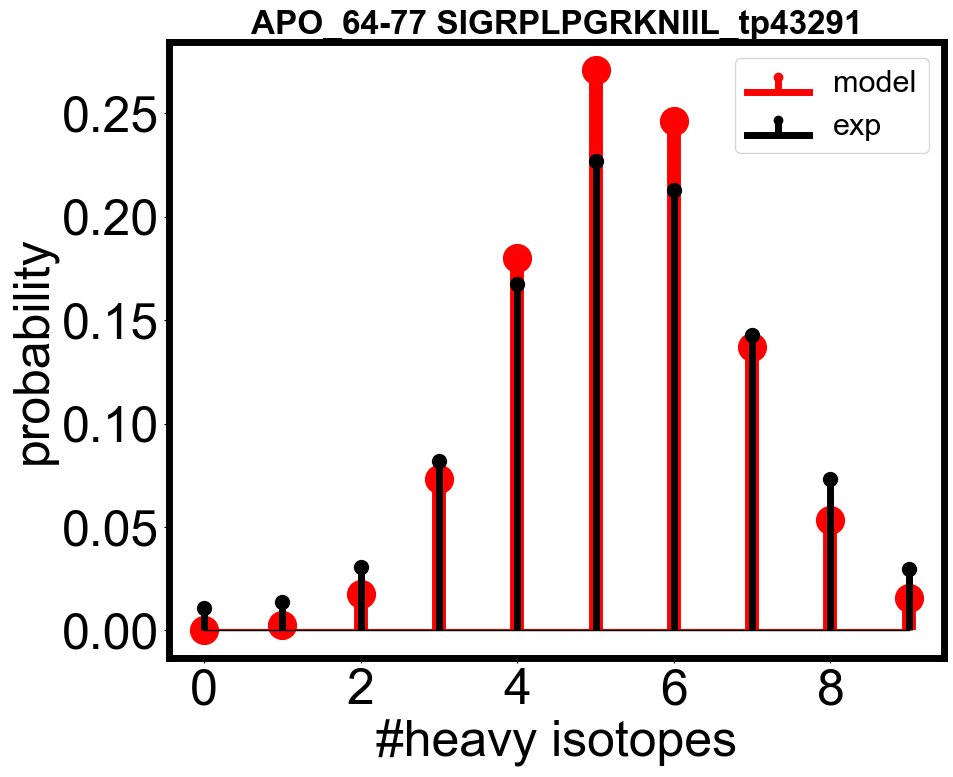

In [21]:
envelope_errors = [(check_fitted_isotope_envelope(ana_apo_1, tp), tp) for tp in all_tps]
envelope_errors = sorted(envelope_errors, key=lambda x: x[0], reverse=False)

# you can plot the fitted isotope envelope and the experimental data
check_fitted_isotope_envelope(check_ana_obj, envelope_errors[300][1], if_plot=True)

Text(0, 0.5, 'Count')

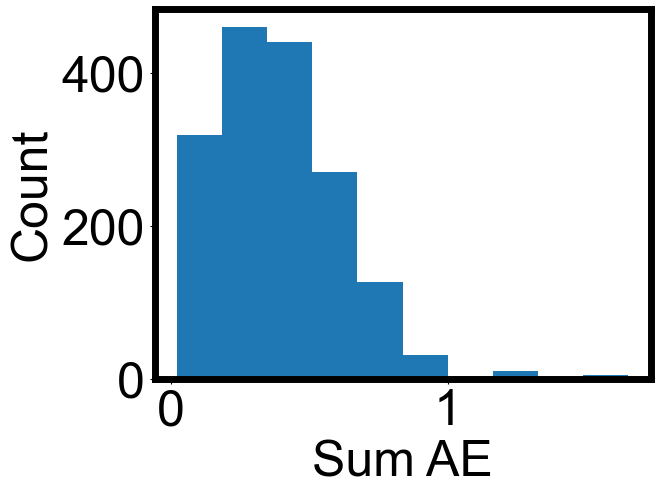

In [22]:
plt.hist(
    np.array(envelope_errors)[:, 0],
)
plt.xlabel("Sum AE")
plt.ylabel("Count")

In [23]:

print(np.nanmedian(np.array(envelope_errors)[:, 0]))
print(np.nanmean(np.array(envelope_errors)[:, 0]))

0.3646019382844139
0.39348193324578395


### uptake check

In [24]:
from pigeon_feather.analysis import check_fitted_peptide_uptake


all_idfs = list(set([pep.identifier for pep in all_peps]))


def extract_numbers(s):
    numbers = re.findall(r"(-?\d+)-(-?\d+)", s)
    return tuple(map(int, numbers[0]))


all_idfs.sort(key=extract_numbers)

In [25]:
uptake_errors = []

all_peps_grouped = tools.group_by_attributes(
    all_peps, ["protein_state.state_name", "identifier"]
)

for idf in all_idfs:
    try:
        idf_peps = all_peps_grouped[(check_state_name, idf)]
        avg_pep = tools.average_peptides(idf_peps)

        result = check_fitted_peptide_uptake(
            check_ana_obj, hdxms_data_list, avg_pep, state_name=check_state_name
        )
        uptake_errors.append((result, avg_pep))
    except Exception as e:
        print(idf, e)


uptake_errors_array = np.array([i[0] for i in uptake_errors])

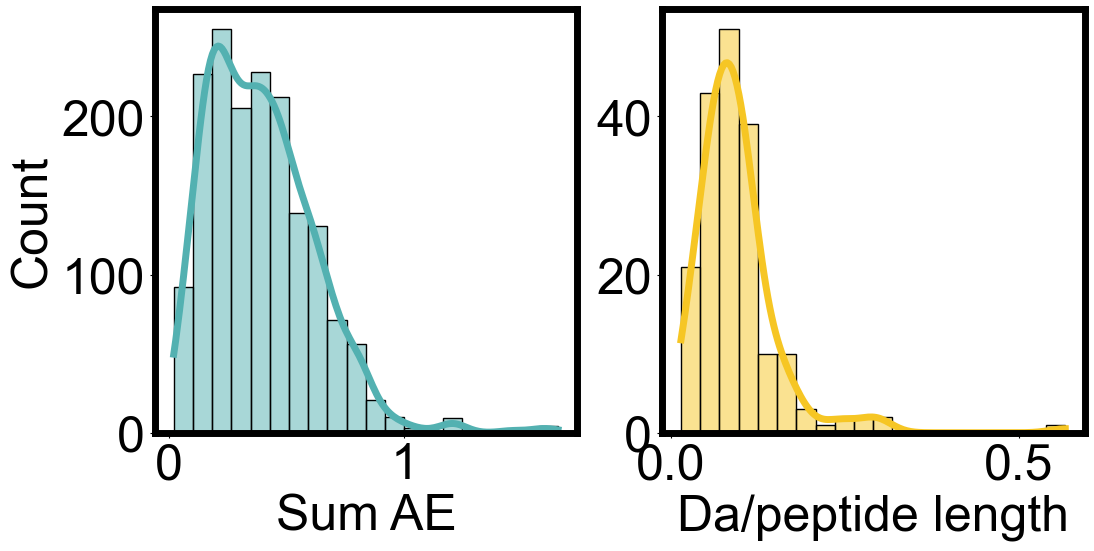

In [26]:
import seaborn as sns


fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

# # Plotting with complementary colors
# sns.histplot([x[0] for x in envelope_errors], bins=20, kde=True, ax=axes[0], color="#FF6347")
# sns.histplot(uptake_errors_array, bins=20, kde=True, ax=axes[1], color="#4682B4")


color_1 = "#53b1b1"  # A standard blue color
color_2 = "#f6c624"  # A teal color

# Plotting with chosen colors
sns.histplot([x[0] for x in envelope_errors], bins=20, kde=True, ax=axes[0], color=color_1)
sns.histplot(uptake_errors_array, bins=20, kde=True, ax=axes[1], color=color_2)

axes[1].set_ylabel("")
axes[0].set_xlabel("Sum AE")
axes[1].set_xlabel("Da/peptide length")
fig.subplots_adjust(wspace=0.2)


In [27]:
from pigeon_feather.analysis import get_index_offset
from matplotlib.ticker import LogLocator


check_ana_obj = ana_apo_1
index_offset = get_index_offset(check_ana_obj, './data/6XG5_TRI.pdb')

uptake_errors = sorted(uptake_errors, key=lambda x: x[1].start, reverse=False)

num_subplots_per_figure = math.ceil(len(uptake_errors) / 2)
# num_subplots_per_figure = 250
num_figures = math.ceil(len(all_idfs) / num_subplots_per_figure)


for fig_index in range(num_figures):
    # Select the subset of errors for the current figure
    selected_uptake_errors = uptake_errors[fig_index * num_subplots_per_figure:(fig_index + 1) * num_subplots_per_figure]
    num_col = math.ceil(len(selected_uptake_errors) / 5)

    fig, axs = plt.subplots(num_col, 5, figsize=(9 * 5, 8 * num_col))  # Adjust subplot size as needed

    for i, error_tuple in enumerate(selected_uptake_errors):


        ax = axs[i // 5, i % 5]


        # Unpack error information
        peptide_data = error_tuple[1]


        ax.axhline(y=peptide_data.max_d, color='lightgray', linestyle='--', linewidth=5)

        check_fitted_peptide_uptake(
            check_ana_obj,
            hdxms_data_list,
            peptide_data,
            if_plot=True,
            state_name=check_state_name,
            figure=fig,
            ax=ax
        )

        #Retrieve and format the peptide identifier
        idf = peptide_data.identifier
        idf_start, idf_end = map(int, re.match(r"(-?\d+)-(-?\d+)", idf).groups())
        idf_seq = idf.split(" ")[1]
        ax.set_title(f"{idf_start - index_offset}-{idf_end - index_offset} {idf_seq}")

        ax.set_xlim(1e1, 1e5)
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))

        # y_max = ax.get_ylim()[1]
        # ax.set_ylim(-0.5, y_max + 1)
        pep = error_tuple[1]
        y_max = pep.theo_max_d/check_ana_obj.saturation
        ax.set_ylim(-0.5, y_max + 0.5)

        # light gray dotted line at max deuteration


        handles, labels = ax.get_legend_handles_labels()
        new_labels = [label for label in labels if label.isdigit()]
        new_handles = [handle for handle, label in zip(handles, labels) if label.isdigit()]
        ax.legend(new_handles, new_labels, title='replicate', title_fontsize='small')

    # Layout adjustment and save
    fig.tight_layout()
    fig.savefig(f"{results_path}/ecDHFR_uptake_errors_{check_state_name}_{fig_index}.pdf")


if the fitting is bad, one should not move forward, need to check the parameters in the sampling, make sure they agree with the experimental conditions. one may also remove the outlier peptides and run the all the cells above again. a ourliter may be a peptide exchange a lot while its neighbours barely exchange (examples in the turtorial dataset: 78-92 VDEAIAACGDVPEIM, 75-78 VKSV)

once you're satisfied with the fitting results, you can make the final results plots

## barplot of the kex

barplot showing the FEATHER derived exchange rates. index_offset is determined by comparison to the sequence in HX/MS and the pdb file provided.

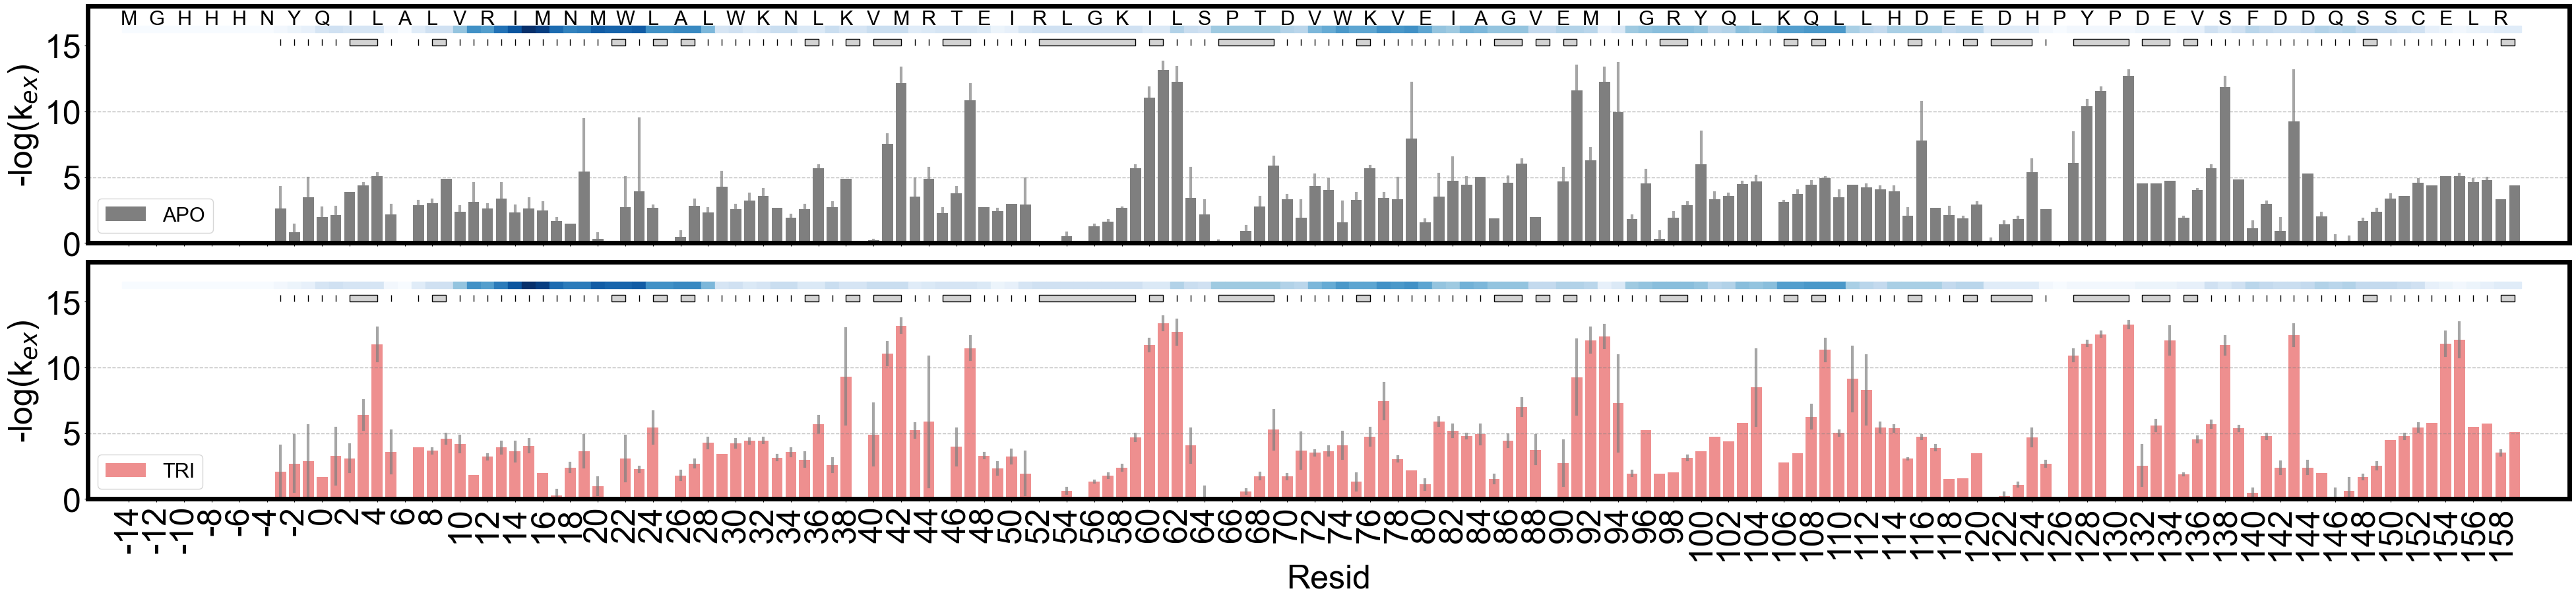

In [28]:
# APO state only

import numpy as np


fig, axes = plt.subplots(2, 1, figsize=(40, 10), sharey=True, sharex=True)

ana_apo_1.plot_kex_bar(
    ax=axes[0], resolution_indicator_pos=15, label="APO", show_seq=False, color="k"
)

ana_tri_1.plot_kex_bar(
    ax=axes[1], resolution_indicator_pos=15, label="TRI", show_seq=False, color="red"
)

from matplotlib.pyplot import step
from matplotlib.ticker import FuncFormatter, MultipleLocator

from pigeon_feather.analysis import get_index_offset

pdb_file = "./data/6XG5_TRI.pdb"
index_offset = get_index_offset(ana_apo_1, pdb_file)

# # ax.xaxis.set_major_locator(plt.MultipleLocator(2))
axes[0].set_xticks(axes[0].get_xticks()[::2])
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontdict={"fontsize": 24})


def format_func(value, tick_number):
    return f"{int(value - index_offset +1)}"


axes[0].xaxis.set_major_formatter(FuncFormatter(format_func))

seq_pos = 17
for ii in range(0, len(ana_apo_1.protein_sequence[:]), 2):
    axes[0].text(
        ii,
        seq_pos,
        ana_apo_1.protein_sequence[ii],
        ha="center",
        va="center",
        fontsize=22,
    )


for ax in axes:
    ax.set_ylabel("-log(k$_{ex}$)")
    #ax.legend(loc="lower left")
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))

    ax.plot(
        [-3, len(ana_apo_1.protein_sequence) + 3],
        [5, 5],
        color="gray",
        lw=1,
        linestyle="--",
        alpha=0.5,
    )
    ax.plot(
        [-3, len(ana_apo_1.protein_sequence) + 3],
        [10, 10],
        color="gray",
        lw=1,
        linestyle="--",
        alpha=0.5,
    )


plt.subplots_adjust(hspace=0.08)
fig.savefig(f"{results_path}/ecDHFR_kex_bar_APO_TRI_{today_date}.pdf")

logP projection to a pdb structure

In [29]:
from pigeon_feather.analysis import BFactorPlot

In [30]:
bfactor_plot = BFactorPlot(
    ana_apo_1,
    pdb_file="./data/6XG5_TRI.pdb",
    plot_deltaG=True,
    temperature=293.15,
    logP_threshold=10,
)
bfactor_plot.plot(f"{results_path}/6XG5_APO_deltaG.pdb")

# bfactor_plot = BFactorPlot(
#     ana_apo_1,
#     pdb_file="./data/6XG5_APO_relaxed_best_solvated.pdb",
#     plot_deltaG=True,
#     temperature=293.15,
# )
# bfactor_plot.plot(f"{out_path}/6XG5_APO_deltaG.pdb")

delta logP

if there are mutiple states availble, one can map the difference to the pdb strutcure

In [31]:
bfactor_plot = BFactorPlot(
    ana_apo_1,
    ana_tri_1,  
    pdb_file="./data/6XG5_TRI.pdb",
    plot_deltaG=True,
    temperature=293.15,
    logP_threshold=10,
)
bfactor_plot.plot(f"{results_path}/6XG5_deltaG_APO-TRI.pdb")

export logPFs to a csv

In [32]:
import MDAnalysis
from pigeon_feather.analysis import get_res_avg_logP, get_res_avg_logP_std

pdb_file = "./data/6XG5_TRI.pdb"
index_offset = get_index_offset(ana_apo_1, pdb_file)


def logPF_to_deltaG(ana_obj, logPF):
    """
    :param logPF: logP value
    :return: deltaG in kJ/mol, local unfolding energy
    """

    return 8.3145 * ana_obj.temperature * np.log(10) * logPF / 1000


def create_logP_df(ana_obj, index_offset):
    df_logPF = pd.DataFrame()

    for res_i, _ in enumerate(ana_obj.results_obj.protein_sequence):
        res_obj_i = ana_obj.results_obj.get_residue_by_resindex(res_i)

        avg_logP, std_logP = get_res_avg_logP(res_obj_i)
        #std_logP = get_res_avg_logP_std(res_obj_i)

        df_i = pd.DataFrame(
            {
                "resid": [res_obj_i.resid - index_offset],
                #"resname": [res_obj_i.resname],
                "resname": [MDAnalysis.lib.util.convert_aa_code(res_obj_i.resname)],
                'avg_dG': [logPF_to_deltaG(ana_obj, avg_logP)],
                'std_dG': [logPF_to_deltaG(ana_obj, std_logP)],
                "avg_logP": [avg_logP],
                "std_logP": [max(std_logP, 0.35)],
                "is_nan": [res_obj_i.is_nan()],
            }
        )

        if res_obj_i.is_nan():
            df_i["single resloved"] = [np.nan]
            df_i["min_pep logPs"] = [np.nan]

        else:
            df_i["single resloved"] = [res_obj_i.mini_pep.if_single_residue()]
            df_i["min_pep logPs"] = [res_obj_i.clustering_results_logP]

        df_logPF = pd.concat([df_logPF, df_i])

    df_logPF = df_logPF.reset_index(drop=True)

    return df_logPF


df = create_logP_df(ana_apo_1, index_offset)
df.to_csv(f"{results_path}/logP_APO_{today_date}.csv", index=False)


In [33]:
# fecth two df and merge
df_apo = create_logP_df(ana_apo_1, index_offset)
df_tri = create_logP_df(ana_tri_1, index_offset)

df = pd.merge(df_apo, df_tri, on="resid", suffixes=("_APO", "_TRI"))

df.to_csv(f"{results_path}/logP_APO_TRI_{today_date}.csv", index=False)